<img width="1600" height="300" alt="QlynixBanner" src="https://github.com/user-attachments/assets/63e268e7-a2da-4de4-851c-4881156fd0c4" />

## Physics-Informed Hybrid Quantum Neural Networks for Clinical Trial Optimization via Pharmacokinetic and Pharmacodynamic Modeling and Simulation

By Achraf Bousshai & Abir Chekroun

This notebook serves as supplementary material for the draft paper submission to the Quantum Innovation Challenge 2025.

### This Notebook Content:

* [Project Overview](#Project-Overview:)
* [Methodology](#Methodology)
    * [One Compartment IV Bolus Model](#One-Compartment-IV-Bolus-Model)
    * [One Compartment with First-Order Oral Absorption Model](#One-Compartment-with-First-Order-Oral-Absorption-Model)
    * [Multiple Dosing event](#Multiple-Dosing-event)
* [Resources Estimation:](#Resources-Estimation:)


### Project Overview:

Pharmacokinetics/Pharmacodynamics (PK/PD) models are essential to understand and simulate new drugs' exposure–response in living bodies. Thus, they serve as an important tool in drug discovery, optimizing the pipeline of clinical trials, and minimizing the associated costs and risks.

The Quantum Innovation Challenge is about leveraging the quantum algorithms' advantages of generalization and trainability in PK/PD modelling and help designing optimal clinical trials.

In this project proposal, we present a Physics-Informed Hybrid Neural Network with a parallel architecture, first introduced by ([Kordzanganeh et al., 2023](https://arxiv.org/abs/2303.03227)) and later extended with physics knowledge feeding by ([Lenog et al., 2025](https://arxiv.org/abs/2503.02202)).

The general architecture of the proposed approach is illustrated in Figure 1. To model PK profiles, it takes a time step (with the potential addition of dosage and covariates to increase biological knowledge) and returns the amount of drug in different compartments.  

The figure shows an architecture for a two-compartment model with first-order absorption, so the outputs are the amounts of drug in the gut $A_g$, central $A_c$, and peripheral $A_p$ compartments. These contribute in different ways to the total loss function: $A_c$ is compared to the data observations to compute the data loss, all compartments are auto-differentiated to compute the physics loss using the descriptive Ordinary Differential Equations (ODEs), and the dosage information along with other assumptions contributes to the initial condition loss.

![K1crGYQ.md.png](https://iili.io/K1crGYQ.md.png)

**Figure 1**: The general architecture of the Physics-Informed Neural Network for a two-compartment model with first-order absorption.


### Methodology

#### One Compartment IV Bolus Model:
To demonstrate our approach, we will generate synthetic PK data points for one subject modeled using a one-compartment model with an IV bolus injection directly into the central compartment, as shown in Figure 2.

![K1ad0nj.png](https://iili.io/K1ad0nj.png)

**Figure 2**: Illustration of one-compartment models with zero-order absorption where the drug is directly injected into the bloodstream.

This model can be represented mathematically using the following ordinary differential equation:

$$
\frac{dA_c}{dt} = -k_{e} \cdot A_c, \quad A_c(0) = \text{Dose}
$$

where:
- $A_c$ = amount of drug in the central compartment  
- $k_{e}$ = elimination rate constant  
- $\text{Dose}$ = initial administered amount of drug (IV bolus)

Thus, the closed-form solution of this equation can be written as:

$$
A_c(t) = A_c(0) \, e^{-k_{e} t}
$$

Since we are interested in the development of the concentration over time, it can be defined as the amount of the drug in the compartment over the volume of distribution: $C(t) = \frac{A_c(t)}{V}$ with $V$ is the volume of distribution.

Using this, the data points can be generated as follows, assuming subject parameters as indicated below:


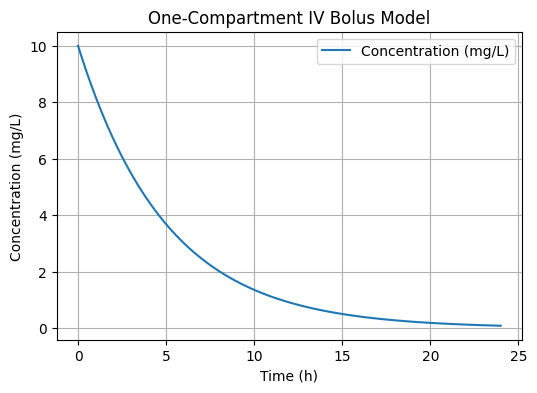

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Subjects parameters ###
dose = 100        #The dosage of the administrated drug is 100 mg
V = 10            #The volume of distribution in L
ke = 0.2         #The elmination constant 
time = np.linspace(0, 24, 100)  

### The closed form solution of the ODE ###
Ac = dose * np.exp(-ke * time)       # The amount of drug in the central compartment
C = Ac / V                            # The concentration of it in the central compartment (mg/L)

### Ploting code ###
plt.figure(figsize=(6,4))
plt.plot(time, C, label="Concentration (mg/L)")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.title("One-Compartment IV Bolus Model")
plt.legend()
plt.grid(True)
plt.show()

Now that we have defined our noiseless data for demonstration purposes, we move on to defining the Physics-Informed Hybrid Quantum Neural Network (PI-HQNN) architecture for this case.  

**The input of the architecture**:  
Since we are aiming to model PK observations, our data points are coupled as $(C, t)$, where $C$ is the concentration of the drug in the central compartment and $t$ is the time step. Our input will therefore be the time, as we are estimating the function $C(t)$. In this part, we do not consider any covariates, and the dosage will only be used to define the initial condition loss.  

**The output**:  
Since we are following a one-compartment model, the only concentration we will be monitoring is that of the central compartment, so the output of both branches will be one node corresponding to $C$.  

**The Quantum Layer of the neural network**:  
Since we have only time as input, we will use a simple architecture with 1 qubit, which is also important for simulation efficiency on simple devices (access to a supercomputer would allow us to try more complex architectures :P). The feature map will be a simple $R_Y$ rotation, and the ansatz will be $R_Z R_X R_Z$. For optimization purposes, we will chain these two components twice, resulting in 6 trainable parameters. The measurement will be the Pauli-Z expectation value.  

**The Classical Layer of the neural network**:  
We will use one hidden layers with 16 nodes, bias and *tanh* as the activation function, with one node for input and one for output.  

Both outputs of the two branches will be joined into one $C$ node as:  

$$
O_{C} = s_q \cdot q_{C} + s_c \cdot c_{C}
$$  

where $s_q$ and $s_c$ determine the amount of contribution of each branch to the output. At this point, we consider them equal with $s_q = s_c = 1$.

**The Total Loss Function and Training Process**  

The total loss function $\mathcal{L}_{\text{total}}$ for such an architecture can be defined as follows:  

$$
\mathcal{L}_{\text{total}} = \lambda_{\text{data}} \cdot \mathcal{L}_{\text{data}} 
+ \lambda_{\text{physics}} \cdot \mathcal{L}_{\text{physics}} 
+ \lambda_{\text{IC}} \cdot \mathcal{L}_{\text{IC}}
$$  

where:  

- $\mathcal{L}_{\text{data}}$ is the *Data Loss*: We compute it with a simple Mean Squared Error (MSE) function between the predicted concentration $C_{\text{pred}}$ and the observed concentration $C_{\text{obs}}$ at a given time step as follows:  

$$
\mathcal{L}_{\text{data}} = \frac{1}{N} \sum_{i=1}^N \big(C_{\text{pred}}(t_i) - C_{\text{obs}}(t_i)\big)^2
$$  

- $\mathcal{L}_{\text{physics}}$ is the *Physics Loss*: This will enforce the ODE equation that we have already defined, so the physics loss is computed as:  

$$
\mathcal{L}_{\text{physics}} = \frac{1}{M} \sum_{j=1}^M \Bigg(\frac{dC_{\text{pred}}(t_j)}{dt} + k_{el} \, C_{\text{pred}}(t_j)\Bigg)^2
$$  

- $\mathcal{L}_{\text{IC}}$ is the *Initial Condition Loss*: This will be used to ensure that the model satisfies the initial condition of dosage at time $0$ and other assumptions when adding covariates and other compartments to the structural model knowledge as follows:  

$$
\mathcal{L}_{\text{IC}} = \big(C_{\text{pred}}(0) - C_0\big)^2
$$  

- And, $\lambda_{\text{data}}$, $\lambda_{\text{physics}}$, and $\lambda_{\text{IC}}$ are coefficients that determine the contribution of each loss term to the total loss and for now these coefficients are not trainable parameters; they can either be set manually or assumed equal (e.g., $\lambda_{\text{data}} = \lambda_{\text{physics}} = \lambda_{\text{IC}} = 1$).


The aim of training the Hybrid Neural Network is to minimize the total loss function, and the parameters will be updated using gradient-based optimization methods.

We would love our model to estimate the ODE parameters as well. In our case, we have the elimination constant $k_e$. Finding it will also be useful for the pipeline. In our architecture, we will consider it as an independent scalar to be optimized together with the hybrid NN parameters. (This step will be given more consideration in future phases of the challenge). Estimating $k_e$ will also help in the population modelling later.

This specific architecture is illustrated in Figure 3:

![https://github.com/user-attachments/assets/d874ddf6-8cc7-4b24-9f7f-caaae78fa1ff](https://github.com/user-attachments/assets/d874ddf6-8cc7-4b24-9f7f-caaae78fa1ff)

**Figure 3**: Diagram of the Physics-Informed Hybrid Quantum Neural Network for the one-compartment model with IV Bolus dosing

Now we start coding all this!

We will use PennyLane for the quantum part, and PyTorch for the classical one. Make sure to install the necessary dependencies...

In [ ]:
pip install pennylane

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pennylane as qml
import torch.nn.functional as F

#Initiate a random seed to ensure reproducibility of results, and 2025, because it's the Quantum Innovation Challenge 2025, isn’t it?
torch.manual_seed(2025)
np.random.seed(2025)

We start by converting our generated data to match the necessary data types:

In [4]:
device_torch = torch.device("cpu") #PyTorch device (can use GPU if available)
t_train_np = time.astype(np.float32)
C_obs_np = C.astype(np.float32)

Now, we define the quantum layer as discussed earlier:

In [5]:
dev = qml.device("default.qubit", wires=1)

# single-qubit QNode with 'torch' interface, backprop diff method
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(q_params, t_scalar):
    """
    q_params: the trainable parameters of the quantum branch as torch tensor
    t_scalar: the time input of the Quantum layer 
    """
    
    ### The Feature Map ###
    qml.RY(t_scalar, wires=0)

    ### The parametrized Ansatz with RZRXRZ ###
    idx = 0
    for _ in range(2):
        qml.RZ(q_params[idx], wires=0)
        qml.RX(q_params[idx + 1], wires=0)
        qml.RZ(q_params[idx + 2], wires=0)
        idx += 3

    return qml.expval(qml.PauliZ(0)) ### PauliZ Expectation Measurmnet

We define the forward pass and our hybrid architecture as an extended class from the nn.Module

In [6]:
class PI_HQNN(nn.Module):
    def __init__(self):
        super().__init__()

        ### We define the classical layer architecture: One input, Three hidden layers of 10 nodes each, One output
        self.classical = nn.Sequential(
            nn.Linear(1, 16), #Each layers have biases built-in within PyTorch nn.Linear
            nn.Tanh(),
            nn.Linear(16, 1)
        )

        
        self.q_map = nn.Linear(1, 1) # This maps the quantum output from the Pauli-Z measurement range, which is usually [-1, 1], to the concentration range of our data.
        
        self.q_params = nn.Parameter(0.01 * torch.randn(6, dtype=torch.float32)) # Randomly initiate the quantum parameters of the ansatz.
        
        self.ke = nn.Parameter(torch.tensor(0.5, dtype=torch.float32)) # Define ke as a trainable parameter with an initial guess of 0.5
        
        self.s_q = 1.0 # Contribution of the quantum output to the total output.
        self.s_c = 1.0 # Contribution of the classical output to the total output.


    def forward(self, t):
        t_flat = t.view(-1) # Torch data type matching
        t_in = t_flat.unsqueeze(1)
        
        classical_out = self.classical(t_in) # Get the output from the classical layer
        
        q_list = [qnode(self.q_params, ti).to(t.dtype) for ti in t_flat] #Run the quantum cirucit for each step
        q_tensor = torch.stack(q_list).unsqueeze(1) 
        q_mapped = self.q_map(q_tensor) #Map the output
        
        combined = self.s_q * q_mapped + self.s_c * classical_out #Combine the Classicaal and the Quantum output
        
        return combined.squeeze(1)


    def get_ke(self):
        return F.softplus(self.ke) #softplus activation function to ensure positivity
        


In [15]:
#Contributions of each data loss to the total loss
lambda_data = 1.0 
lambda_physics = 1.0
lambda_IC = 1.0

# instantiate the model
model = PI_HQNN().to(device_torch)

#define the optimizer to minimize the loss and train the Neural Network, we chose the Adam Optimizer with a learning rate of 0.02
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

t_train = torch.tensor(t_train_np, dtype=torch.float32, device=device_torch) #convert the time steps to numpy tensor
C_obs_t = torch.tensor(C_obs_np, dtype=torch.float32, device=device_torch) #create the tensor of the output

'''
Here, we define 60 checkpoints that are evenly distributed over the time range we have, 
These will serve to check the physics loss outside the time steps to enforce generalization beyond only seen data.
'''
M = 60
t_collocation = np.linspace(0, 24, M).astype(np.float32)


# Epochs and printing stuff
n_epochs = 800
print_every = 100


Now we define the loss function and what happens in one epoch of training!

In [16]:
history = {
    "total_loss": [],
    "data_loss": [],
    "physics_loss": [],
    "ic_loss": [],
    "ke": []
    }

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    C_pred = model(t_train)
    data_loss = torch.mean((C_pred - C_obs_t) ** 2)

    
    #### The physics loss
    physics_loss = torch.tensor(0.0, dtype=torch.float32, device=device_torch)
    for tt in t_collocation:
        t_var = torch.tensor(float(tt), dtype=torch.float32, device=device_torch, requires_grad=True)
        C_t = model(t_var)
        dC_dt = torch.autograd.grad(C_t, t_var, create_graph=True)[0]
        ke = model.get_ke()
        res = dC_dt + ke * C_t
        physics_loss = physics_loss + res ** 2
    physics_loss = physics_loss / float(M)
    ###

    
    ### The initial condition loss
    t0 = torch.tensor(0.0, dtype=torch.float32, device=device_torch, requires_grad=True)
    C0_pred = model(t0)
    V_pred = 10 #We will assume in this case that V is known; it can be considered as a trainable parameter in the future. We kept it to consider the initial condition  loss too
    C0_expected = dose / V_pred
    ic_loss = (C0_pred - C0_expected) ** 2
    ###

    
    loss_total = lambda_data * data_loss + lambda_physics * physics_loss + lambda_IC * ic_loss # The total loss

    
    
    # Example: update inside training loop
    history["total_loss"].append(loss_total.item())
    history["data_loss"].append(data_loss.item())
    history["physics_loss"].append(physics_loss.item())
    history["ic_loss"].append(ic_loss.item())
    history["ke"].append(model.get_ke().item())
    

    # Optimization and updating parameters
    loss_total.backward() 
    optimizer.step()


    ### prinitng epoch results
    if epoch % print_every == 0 or epoch == 1:
        with torch.no_grad():
            ke_val = model.get_ke().item()
            print(
                f"Epoch {epoch:4d} | Loss={loss_total.item():.6f} "
                f"| data={data_loss.item():.6e} phys={physics_loss.item():.6e} ic={ic_loss.item():.6e} "
                f"| k_e={ke_val:.4f}"
            )
    ###

Epoch    1 | Loss=139.501343 | data=1.726774e+01 phys=1.560388e+00 ic=1.206732e+02 | k_e=0.9679
Epoch  100 | Loss=0.930241 | data=1.616611e-01 phys=7.200481e-01 ic=4.853155e-02 | k_e=0.4453
Epoch  200 | Loss=0.167299 | data=4.244595e-02 phys=1.248380e-01 ic=1.521412e-05 | k_e=0.2900
Epoch  300 | Loss=0.062250 | data=1.738553e-02 phys=4.486174e-02 ic=2.342881e-06 | k_e=0.2408
Epoch  400 | Loss=0.028299 | data=7.806529e-03 phys=2.049200e-02 ic=3.842615e-09 | k_e=0.2182
Epoch  500 | Loss=0.014339 | data=3.427682e-03 phys=1.091063e-02 ic=8.788347e-07 | k_e=0.2068
Epoch  600 | Loss=0.008149 | data=1.486554e-03 phys=6.660677e-03 ic=2.095770e-06 | k_e=0.2009


We evaluate and print the performance of the model:

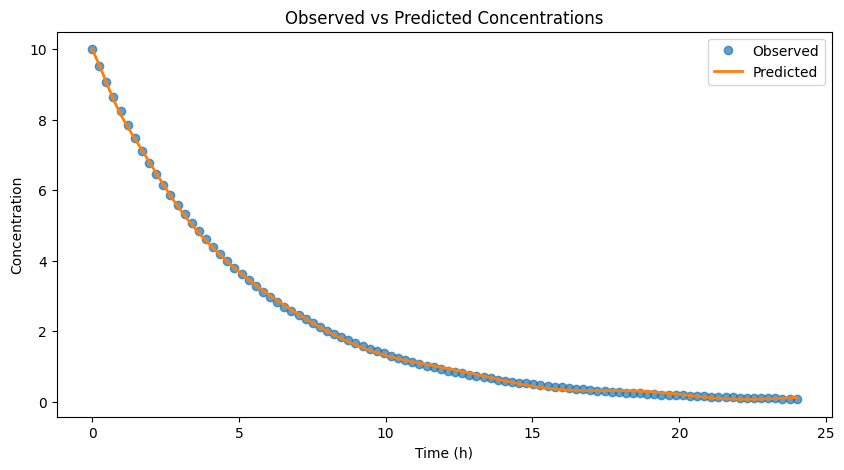

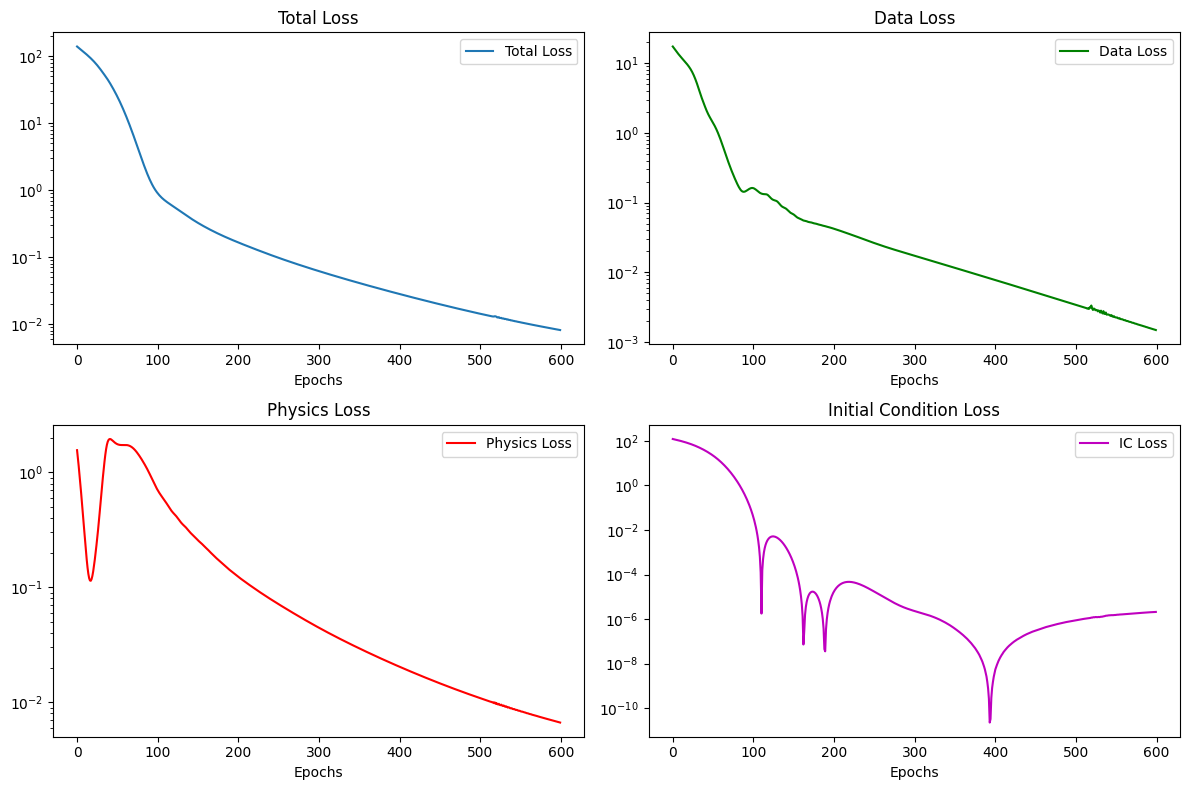

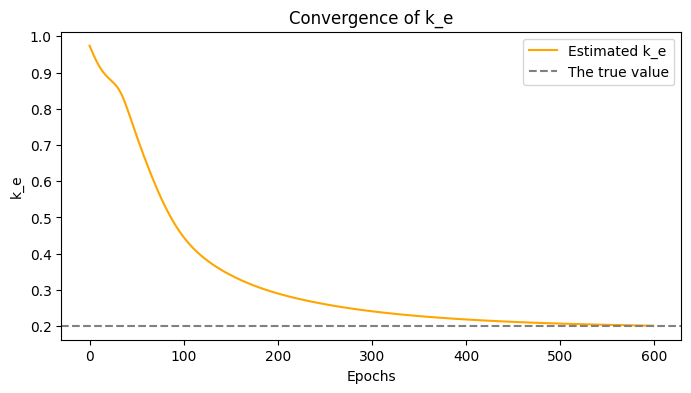

In [31]:
with torch.no_grad():
    C_pred_final = model(t_train).cpu().numpy()
plt.figure(figsize=(10,5))
plt.plot(t_train.cpu().numpy(), C_obs_np, "o", label="Observed", alpha=0.7)
plt.plot(t_train.cpu().numpy(), C_pred_final, "-", label="Predicted", lw=2)
plt.xlabel("Time (h)")
plt.ylabel("Concentration")
plt.legend()
plt.title("Observed vs Predicted Concentrations")
plt.show()


### 2) Loss Curves
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()

axs[0].plot(history["total_loss"], label="Total Loss")
axs[0].set_title("Total Loss")
axs[0].set_yscale("log")

axs[1].plot(history["data_loss"], label="Data Loss", color="g")
axs[1].set_title("Data Loss")
axs[1].set_yscale("log")


axs[2].plot(history["physics_loss"], label="Physics Loss", color="r")
axs[2].set_title("Physics Loss")
axs[2].set_yscale("log")

axs[3].plot(history["ic_loss"], label="IC Loss", color="m")
axs[3].set_title("Initial Condition Loss")
axs[3].set_yscale("log")

for ax in axs:
    ax.set_xlabel("Epochs")
    ax.legend()
plt.tight_layout()
plt.show()


### 3) Estimated k_e
plt.figure(figsize=(8,4))
plt.plot(history["ke"], label="Estimated k_e", color="orange")
plt.axhline(y=0.2, linestyle="--", color="gray", label="The true value")
plt.xlabel("Epochs")
plt.ylabel("k_e")
plt.title("Convergence of k_e")
plt.legend()
plt.show()

In [35]:
model.eval()
with torch.no_grad():
    C_pred_final = model(t_train).cpu().numpy()
    learned_ke = model.get_ke().item()

print("\nLearned parameters:")
print(f"  k_e (true) = {0.2:.4f}, learned = {learned_ke:.4f}")



Learned parameters:
  k_e (true) = 0.2000, learned = 0.2009


The model perfectly learned the constant k_e!

---
#### One Compartment with First-Order Oral Absorption Model

We have demonstrated that our model performed perfectly on the previous model; now we try another, more complex structural assumption with synthetic noiseless data to assess the performance of our hybrid architecture.

We define a one-compartment model, but instead of assuming that the drug is directly dosed into the central compartment, we give the drug as an oral (extravenous) dose. Therefore, we need to consider the absorption phase of the therapeutic before it reaches the bloodstream. This system is shown in Figure 4:

![KE3ntGS.png](https://iili.io/KE3ntGS.png)

**Figure 4:** Illustration of a one-compartment model with first-order absorption where the drug is administered as an oral dose.

This model can be represented mathematically using the following ordinary differential equation:

$$
\frac{dA_c}{dt} = k_a \cdot A_g - k_e \cdot A_c, \quad A_c(0) = 0
$$

$$
\frac{dA_g}{dt} = -k_a \cdot A_g, \quad A_g(0) = \text{Dose}
$$

where:  
- $A_c$ = amount of drug in the central compartment  
- $A_g$ = amount of drug in the gut (absorption site)  
- $k_e$ = elimination rate constant  
- $k_a$ = absorption rate constant  

Thus, the closed-form solution of this equation can be written as:

$$
A_c(t) = \frac{k_a \cdot \text{Dose}}{k_a - k_e} \left(e^{-k_e t} - e^{-k_a t}\right)
$$

If you refer to our paper, you will notice that we assumed the bioavailability constant here, for simplicity, equal to 1.

Since we are interested in the development of the concentration over time, it can be defined as the amount of the drug in the compartment over the volume of distribution: $ C(t) = \frac{A_c(t)}{V} $ where $V$ is the volume of distribution.

Using this, the data points can be generated as follows, assuming subject parameters as indicated below:



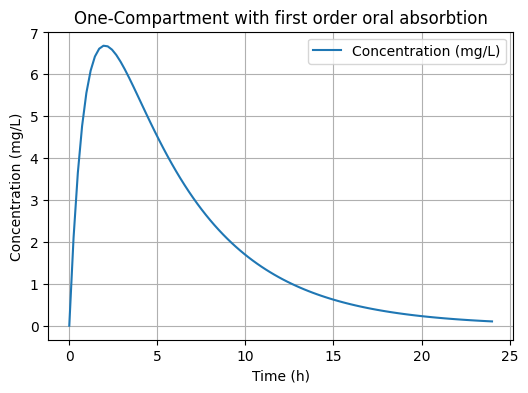

In [3]:
dose = 100.0        # Dose of the administered drug
V_true = 10.0       # The volume of distribution (Assumed known here)
ke_true = 0.2       # Elimination rate
ka_true = 1.0       # Absorption rate
time = np.linspace(0, 24, 100)  

# closed-form solution 
C_obs = (dose * ka_true) / (V_true * (ka_true - ke_true)) * (np.exp(-ke_true * time) - np.exp(-ka_true * time))

### Ploting code ###
plt.figure(figsize=(6,4))
plt.plot(time, C_obs, label="Concentration (mg/L)")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.title("One-Compartment with first order oral absorbtion")
plt.legend()
plt.grid(True)
plt.show()

We use the same principles as with the one-compartment model by modifying the architecture described in Figure 03.  

**The input**: Time steps  

**The output**: Each branch, and therefore the network, will output be the amount of drug in the central compartment $A_c$.  

**The Quantum Layer of the neural network**:  We will repeat the Feature Map - Ansatz chain three times here and we will use only one qubit for efficiency 

**The Classical Layer of the neural network**:  We will use one hidden layers with 16 nodes each, bias, and *tanh* as the activation function, with one node for input and two for output, like the previous noe

Both outputs of the two branches will be joined into one node $A_c$  

Our model will independently optimize the constants of elimination and absorption, $k_e$ and $k_a$ respectively, and we will assume $V$ as a known parameter for simplicity.


We directly implement the same code as we did before, with the changes we have defined, The logic of the loss fucntion remains the same:

In [5]:
device_torch = torch.device("cpu")
t_train_np = time.astype(np.float32)
C_obs_np = C_obs.astype(np.float32)



### Quantum Architecture:

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(q_params, t_scalar):
    alpha = 1.0
    qml.RY(alpha * t_scalar, wires=0)
    idx = 0
    for _ in range(4):
        qml.RZ(q_params[idx], wires=0)
        qml.RX(q_params[idx + 1], wires=0)
        qml.RZ(q_params[idx + 2], wires=0)
        idx += 3
    return qml.expval(qml.PauliZ(0))


class PI_HQNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Classical branch
        self.classical = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

        self.q_map = nn.Linear(1, 1)
        self.q_params = nn.Parameter(0.01 * torch.randn(12, dtype=torch.float32))

        # Trainable ka and ke
        self.ke = nn.Parameter(torch.tensor(0.5, dtype=torch.float32)) #initial guess 0.5
        self.ka = nn.Parameter(torch.tensor(0.5, dtype=torch.float32)) 

        # Scalar mixing weights
        self.s_q = 1.0
        self.s_c = 1.0

    def forward(self, t):
            t_flat = t.view(-1)
            t_in = t_flat.unsqueeze(1)
            classical_out = self.classical(t_in)
            q_list = []
            for ti in t_flat:
                q_val = qnode(self.q_params, ti).to(t.dtype)
                q_list.append(q_val)
            q_tensor = torch.stack(q_list).unsqueeze(1)
            q_mapped = self.q_map(q_tensor)
            return (self.s_q * q_mapped + self.s_c * classical_out).squeeze(1)

    def get_ke(self):
        return F.softplus(self.ke)
    
    def get_ka(self):
        return F.softplus(self.ka)


history = {
    "total_loss": [],
    "data_loss": [],
    "physics_loss": [],
    "ic_loss": [],
    "ke": [],
    "ka": []
    }


lambda_data = 1.0
lambda_physics = 1.0
lambda_IC = 1.0

torch.manual_seed(0)
model = PI_HQNN().to(device_torch)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

t_train = torch.tensor(t_train_np, dtype=torch.float32, device=device_torch)
C_obs_t = torch.tensor(C_obs_np, dtype=torch.float32, device=device_torch)

M = 60
t_collocation = np.linspace(0, 24, M).astype(np.float32)

### Training...

n_epochs = 1000
print_every = 100

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    ## Data Loss
    C_pred = model(t_train)
    data_loss = torch.mean((C_pred - C_obs_t) ** 2)

    # Physics Loss 
    physics_loss = torch.tensor(0.0, dtype=torch.float32, device=device_torch)
    for tt in t_collocation:
        t_var = torch.tensor(float(tt), dtype=torch.float32, device=device_torch, requires_grad=True)
        C_t = model(t_var)
        dC_dt = torch.autograd.grad(C_t, t_var, create_graph=True)[0]
        ke = model.get_ke()
        ka = model.get_ka()
        v = torch.tensor(10.0, dtype=torch.float32, device=device_torch)
        res = (dC_dt + ke * C_t - ka * dose / v * torch.exp(-ka * t_var)).squeeze()
        physics_loss += res ** 2
    physics_loss /= float(M)

    # 3) Initial Condition Loss: C(0) = 0
    t0 = torch.tensor(0.0, dtype=torch.float32, device=device_torch, requires_grad=True)
    C0_pred = model(t0)
    ic_loss = (C0_pred - 0.0) ** 2

    # Total loss
    loss_total = lambda_data * data_loss + lambda_physics * physics_loss + lambda_IC * ic_loss
    loss_total.backward()
    optimizer.step()


    history["total_loss"].append(loss_total.item())
    history["data_loss"].append(data_loss.item())
    history["physics_loss"].append(physics_loss.item())
    history["ic_loss"].append(ic_loss.item())
    history["ke"].append(model.get_ke().item())
    history["ka"].append(model.get_ka().item())
    

    

    if epoch % print_every == 0 or epoch == 1:
        with torch.no_grad():
            print(
                f"Epoch {epoch:4d} | Loss={loss_total.item():.6f} "
                f"| data={data_loss.item():.6e} phys={physics_loss.item():.6e} ic={ic_loss.item():.6e} "
                f"| k_e={model.get_ke().item():.4f} ka={model.get_ka().item():.4f} "
            )


model.eval()
with torch.no_grad():
    C_pred_final = model(t_train).cpu().numpy()
    learned_ke = model.get_ke().item()
    learned_ka = model.get_ka().item()

print("\nLearned parameters:")
print(f"  k_e (true) = {ke_true:.4f}, learned = {learned_ke:.4f}")
print(f"  k_a (true) = {ka_true:.4f}, learned = {learned_ka:.4f}")

Epoch    1 | Loss=9.540509 | data=4.731863e+00 phys=3.641808e+00 ic=1.166838e+00 | k_e=0.9679 ka=0.9679 
Epoch  100 | Loss=0.562802 | data=2.208186e-01 phys=3.315402e-01 ic=1.044367e-02 | k_e=0.4640 ka=0.6204 
Epoch  200 | Loss=0.102228 | data=3.227239e-02 phys=6.770306e-02 ic=2.252654e-03 | k_e=0.2826 ka=0.6559 
Epoch  300 | Loss=0.036078 | data=1.480774e-02 phys=2.040247e-02 ic=8.673042e-04 | k_e=0.2364 ka=0.7231 
Epoch  400 | Loss=0.014173 | data=6.158883e-03 phys=7.696640e-03 ic=3.176130e-04 | k_e=0.2192 ka=0.7923 
Epoch  500 | Loss=0.005618 | data=2.302937e-03 phys=3.212536e-03 ic=1.024374e-04 | k_e=0.2119 ka=0.8487 
Epoch  600 | Loss=0.002330 | data=8.281487e-04 phys=1.473023e-03 ic=2.895920e-05 | k_e=0.2086 ka=0.8885 
Epoch  700 | Loss=0.001154 | data=3.374775e-04 phys=8.096344e-04 ic=6.725868e-06 | k_e=0.2071 ka=0.9141 
Epoch  800 | Loss=0.000744 | data=1.939615e-04 phys=5.494159e-04 ic=1.078527e-06 | k_e=0.2062 ka=0.9296 
Epoch  900 | Loss=0.000586 | data=1.544459e-04 phys=4.3

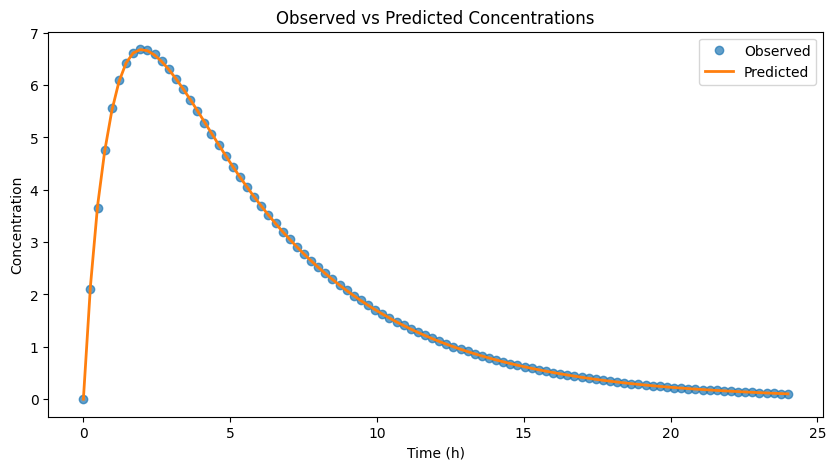

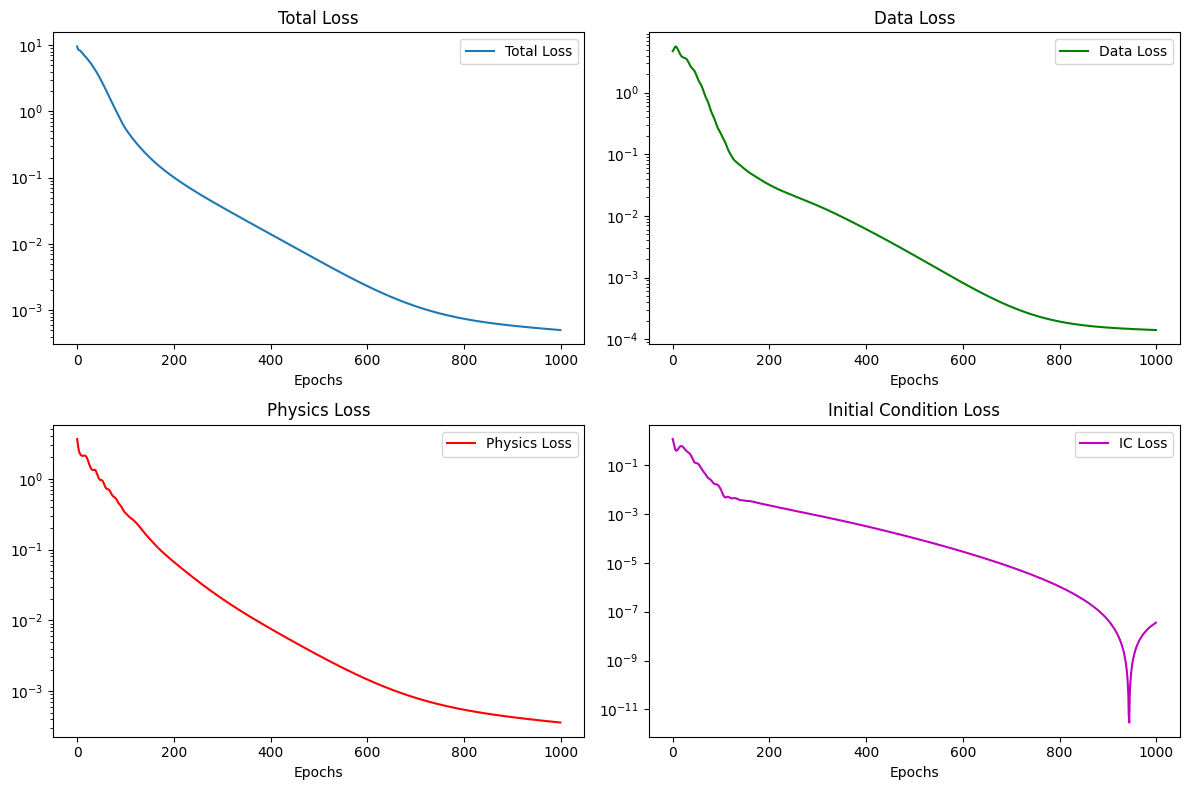

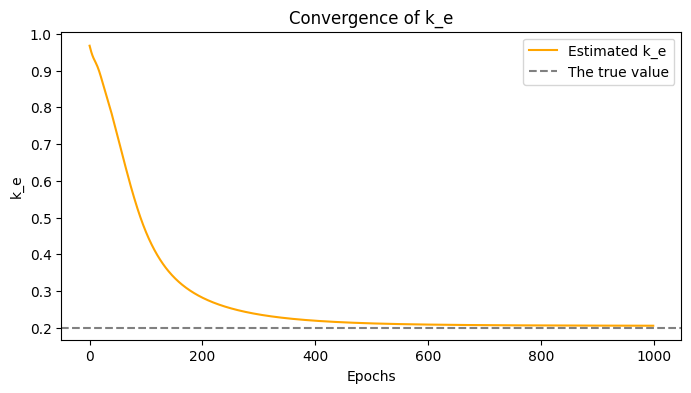

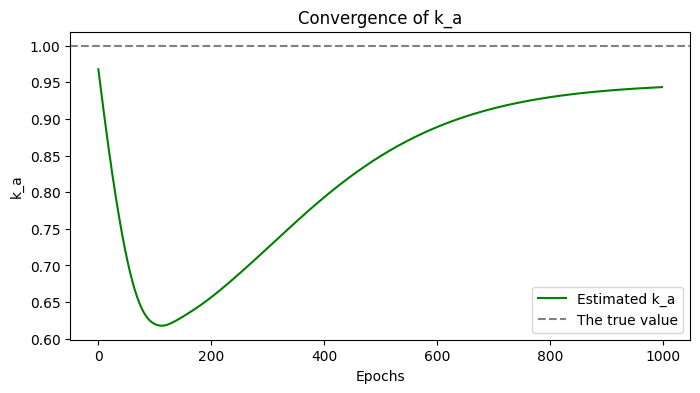

In [6]:
with torch.no_grad():
    C_pred_final = model(t_train).cpu().numpy()
plt.figure(figsize=(10,5))
plt.plot(t_train.cpu().numpy(), C_obs_np, "o", label="Observed", alpha=0.7)
plt.plot(t_train.cpu().numpy(), C_pred_final, "-", label="Predicted", lw=2)
plt.xlabel("Time (h)")
plt.ylabel("Concentration")
plt.legend()
plt.title("Observed vs Predicted Concentrations")
plt.show()


### 2) Loss Curves
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()

axs[0].plot(history["total_loss"], label="Total Loss")
axs[0].set_title("Total Loss")
axs[0].set_yscale("log")

axs[1].plot(history["data_loss"], label="Data Loss", color="g")
axs[1].set_title("Data Loss")
axs[1].set_yscale("log")


axs[2].plot(history["physics_loss"], label="Physics Loss", color="r")
axs[2].set_title("Physics Loss")
axs[2].set_yscale("log")

axs[3].plot(history["ic_loss"], label="IC Loss", color="m")
axs[3].set_title("Initial Condition Loss")
axs[3].set_yscale("log")

for ax in axs:
    ax.set_xlabel("Epochs")
    ax.legend()
plt.tight_layout()
plt.show()


### 3) Estimated k_e
plt.figure(figsize=(8,4))
plt.plot(history["ke"], label="Estimated k_e", color="orange")
plt.axhline(y=0.2, linestyle="--", color="gray", label="The true value")
plt.xlabel("Epochs")
plt.ylabel("k_e")
plt.title("Convergence of k_e")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history["ka"], label="Estimated k_a", color="green")
plt.axhline(y=1.0, linestyle="--", color="gray", label="The true value")
plt.xlabel("Epochs")
plt.ylabel("k_a")
plt.title("Convergence of k_a")
plt.legend()
plt.show()

#### Multiple Dosing event

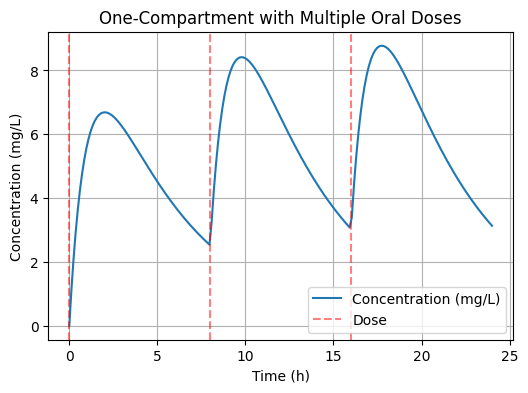

In [5]:
dose = 100.0        # mg per dose
V_true = 10.0       # L
ke_true = 0.2       # Elimination rate
ka_true = 1.0       # Absorption rate

# Define dosing times (every 8h, for example)
dosing_times = np.array([0, 8, 16], dtype=np.float32)
total_time = 24
time = np.linspace(0, total_time, 200)

# Compute observed concentration (closed-form solution for demonstration)
C_obs = np.zeros_like(time)
for t_dose in dosing_times:
    idx = time >= t_dose
    t_rel = time[idx] - t_dose
    C_obs[idx] += (dose * ka_true) / (V_true * (ka_true - ke_true)) * (np.exp(-ke_true * t_rel) - np.exp(-ka_true * t_rel))

# -----------------------
# Plot observed data
# -----------------------
plt.figure(figsize=(6,4))
plt.plot(time, C_obs, label="Concentration (mg/L)")
for t_d in dosing_times:
    plt.axvline(t_d, color='r', linestyle='--', alpha=0.5, label="Dose" if t_d == dosing_times[0] else "")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.title("One-Compartment with Multiple Oral Doses")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Quantum Architecture
# -----------------------
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(q_params, t_scalar):
    alpha = 1.0
    qml.RY(alpha * t_scalar, wires=0)
    idx = 0
    for _ in range(6):
        qml.RZ(q_params[idx], wires=0)
        qml.RX(q_params[idx + 1], wires=0)
        qml.RZ(q_params[idx + 2], wires=0)
        idx += 3
    return qml.expval(qml.PauliZ(0))

# -----------------------
# PI-HQNN Class
# -----------------------
class PI_HQNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Classical branch
        self.classical = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

        self.q_map = nn.Linear(1, 1)
        self.q_params = nn.Parameter(0.01 * torch.randn(18, dtype=torch.float32))

        # Trainable ka and ke
        self.ke = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))
        self.ka = nn.Parameter(torch.tensor(0.5, dtype=torch.float32))

        # Scalar mixing weights
        self.s_q = 1.0
        self.s_c = 1.0

    def forward(self, t):
        t_flat = t.view(-1)
        t_in = t_flat.unsqueeze(1)
        classical_out = self.classical(t_in)
        q_list = []
        for ti in t_flat:
            q_val = qnode(self.q_params, ti).to(t.dtype)
            q_list.append(q_val)
        q_tensor = torch.stack(q_list).unsqueeze(1)
        q_mapped = self.q_map(q_tensor)
        return (self.s_q * q_mapped + self.s_c * classical_out).squeeze(1)

    def get_ke(self):
        return F.softplus(self.ke)
    
    def get_ka(self):
        return F.softplus(self.ka)

# -----------------------
# Training Setup
# -----------------------
device = torch.device("cpu")
t_train = torch.tensor(time.astype(np.float32), dtype=torch.float32, device=device)
C_obs_t = torch.tensor(C_obs.astype(np.float32), dtype=torch.float32, device=device)

history = {"total_loss": [], "data_loss": [], "physics_loss": [], "ic_loss": [], "ke": [], "ka": []}
lambda_data = 1.0
lambda_physics = 1.0
lambda_IC = 1.0

model = PI_HQNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

M = 60
t_collocation = np.linspace(0, total_time, M).astype(np.float32)

# -----------------------
# Training Loop
# -----------------------
n_epochs = 500
print_every = 20

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Data loss
    C_pred = model(t_train)
    data_loss = torch.mean((C_pred - C_obs_t) ** 2)

    # Physics loss
    physics_loss = torch.tensor(0.0, dtype=torch.float32, device=device)
    for tt in t_collocation:
        t_var = torch.tensor(float(tt), dtype=torch.float32, device=device, requires_grad=True)
        C_t = model(t_var)
        dC_dt = torch.autograd.grad(C_t, t_var, create_graph=True)[0]
        ke = model.get_ke()
        ka = model.get_ka()
        v = torch.tensor(10.0, dtype=torch.float32, device=device)

        # Sum over all doses
        dose_sum = torch.tensor(0.0, dtype=torch.float32, device=device)
        for t_dose in dosing_times:
            if tt >= t_dose:
                dose_sum += dose * ka * torch.exp(-ka * (t_var - t_dose)) / v

        res = (dC_dt + ke * C_t - dose_sum).squeeze()
        physics_loss += res ** 2
    physics_loss /= float(M)

    # Initial condition loss: C(0)=0
    t0 = torch.tensor(0.0, dtype=torch.float32, device=device, requires_grad=True)
    C0_pred = model(t0)
    ic_loss = (C0_pred - 0.0) ** 2

    # Total loss
    loss_total = lambda_data * data_loss + lambda_physics * physics_loss + lambda_IC * ic_loss
    loss_total.backward()
    optimizer.step()

    

    # Logging
    history["total_loss"].append(loss_total.item())
    history["data_loss"].append(data_loss.item())
    history["physics_loss"].append(physics_loss.item())
    history["ic_loss"].append(ic_loss.item())
    history["ke"].append(model.get_ke().item())
    history["ka"].append(model.get_ka().item())

    # Save checkpoint every epoch (or every N epochs)
    


    if epoch % print_every == 0 or epoch == 1:
        print(
            f"Epoch {epoch:4d} | Loss={loss_total.item():.6f} "
            f"| data={data_loss.item():.6e} phys={physics_loss.item():.6e} ic={ic_loss.item():.6e} "
            f"| k_e={model.get_ke().item():.4f} ka={model.get_ka().item():.4f}"
        )

        

# -----------------------
# Evaluation
# -----------------------
model.eval()
with torch.no_grad():
    C_pred_final = model(t_train).cpu().numpy()
    learned_ke = model.get_ke().item()
    learned_ka = model.get_ka().item()

print("\nLearned parameters:")
print(f"  k_e (true) = {ke_true:.4f}, learned = {learned_ke:.4f}")
print(f"  k_a (true) = {ka_true:.4f}, learned = {learned_ka:.4f}")

# Plot predictions
plt.figure(figsize=(6,4))
plt.plot(time, C_obs, label="Observed")
plt.plot(time, C_pred_final, label="Predicted", linestyle='--')
for t_d in dosing_times:
    plt.axvline(t_d, color='r', linestyle='--', alpha=0.5, label="Dose" if t_d == dosing_times[0] else "")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg/L)")
plt.title("Predicted vs Observed - Multiple Doses")
plt.legend()
plt.grid(True)
plt.show()

### Resources Estimation:

In [1]:
import math

def estimate_pihqnn_resources(
    N_subj=1,        # number of subjects
    N_t=100,         # number of training time points per subject
    M=60,            # number of collocation points for physics loss
    N_qubits=1,      # number of qubits
    N_layers=2,      # number of ansatz layers
    epochs=800,      # training epochs
    hidden_dim=16,   # hidden dimension of classical net
    flop_per_tanh=10 # FLOP proxy per tanh
):
    # -------------------------------
    # Classical NN FLOPs per forward
    # Architecture: 1 -> hidden_dim -> 1
    # -------------------------------
    flops_linear1 = 2 * (1 * hidden_dim)     # mult + add
    flops_linear2 = 2 * (hidden_dim * 1)
    flops_tanh = flop_per_tanh * hidden_dim
    flops_classical_forward = flops_linear1 + flops_linear2 + flops_tanh

    # Total classical forward across data, collocation, and IC
    flops_classical_per_epoch = (N_t + M + 1) * flops_classical_forward
    # Backprop ~ 3x forward
    flops_classical_per_epoch *= 3

    # -------------------------------
    # Quantum circuit FLOPs per forward
    # Each layer: RZ-RX-RZ (3 gates), feature map RY (1 gate) at start
    
    gates_per_layer = 3
    N_gates = 1 + N_layers * gates_per_layer

    # FLOPs per gate sim ~ c * 2^N_qubits
    flop_per_gate = 16 * (2 ** N_qubits)

    # Data forward cost
    flops_q_data = N_t * N_gates * flop_per_gate
    # Physics cost (scaled by parameters per gate)
    N_params = N_layers * gates_per_layer
    flops_q_physics = M * N_gates * N_params * flop_per_gate
    # IC cost
    flops_q_ic = N_gates * flop_per_gate
    flops_quantum_per_epoch = flops_q_data + flops_q_physics + flops_q_ic

    
    ### Total = Quantum +Classical
    
    flops_per_epoch_per_subject = flops_classical_per_epoch + flops_quantum_per_epoch
    flops_total = flops_per_epoch_per_subject * epochs * N_subj

    
    ### Memory estimation
    # Classical parameters: W1 (1xH), b1(H), W2(Hx1), b2(1) = 2H + 2
    
    params_classical = 2 * hidden_dim + 2
    # Quantum parameters = N_params
    params_quantum = N_params
    params_total = params_classical + params_quantum

    # Memory (float32 = 4 bytes)
    memory_params = params_total * 4  # bytes
    
    # Activation memory (per subject per epoch) ~ storing outputs for backprop
    memory_activations = (N_t + M) * (hidden_dim + 1) * 4
    memory_total_bytes = memory_params + memory_activations

    # -------------------------------
    # Print report
    # -------------------------------
    print("===== PI-HQNN Resource Estimation =====")
    print(f"Subjects              : {N_subj}")
    print(f"Training time points  : {N_t}")
    print(f"Collocation points    : {M}")
    print(f"Qubits                : {N_qubits}")
    print(f"Ansatz layers         : {N_layers}")
    print(f"Epochs                : {epochs}")
    print("---------------------------------------")
    print(f"Classical FLOPs/epoch/subject : {flops_classical_per_epoch:,}")
    print(f"Quantum FLOPs/epoch/subject   : {flops_quantum_per_epoch:,}")
    print(f"Total FLOPs/epoch/subject     : {flops_per_epoch_per_subject:,}")
    print(f"Total FLOPs (all training)    : {flops_total:,}")
    print("---------------------------------------")
    print(f"Parameters total              : {params_total} (float32)")
    print(f"Memory for parameters         : {memory_params/1024:.2f} KB")
    print(f"Memory for activations        : {memory_activations/1024:.2f} KB")
    print(f"Estimated memory (total)      : {memory_total_bytes/1024:.2f} KB")
    print("=======================================")


# Example usage
estimate_pihqnn_resources(
    N_subj=1, N_t=100, M=60, N_qubits=1, N_layers=2, epochs=800, hidden_dim=16
)


===== PI-HQNN Resource Estimation =====
Subjects              : 1
Training time points  : 100
Collocation points    : 60
Qubits                : 1
Ansatz layers         : 2
Epochs                : 800
---------------------------------------
Classical FLOPs/epoch/subject : 108,192
Quantum FLOPs/epoch/subject   : 103,264
Total FLOPs/epoch/subject     : 211,456
Total FLOPs (all training)    : 169,164,800
---------------------------------------
Parameters total              : 43 (float32)
Memory for parameters         : 0.17 KB
Memory for activations        : 10.62 KB
Estimated memory (total)      : 10.79 KB
